# Assignment 02

Created On : Mon Nov 01 2021

Last Modified : Sun Nov 14 2021

Course : MSBD5008

In [1]:
# Import Library
import networkx as nx
import numpy as np
import pickle as pkl
import dgl
import time
import pandas as pd
# For building a graph network
import torch.nn as nn
import torch.nn.functional as F
import torch
# For training and evaluation
import torch.optim as optim
# ppt import
from dgl.nn import GINConv
# For Plotting the Graph
import matplotlib.pyplot as plt

Using backend: pytorch


# Define the Functions To Be Used in the Code

In [2]:
### Define the Train Function
def train(model, features, labels, train_mask, epoch_val, optimizer):
    """ The purpose of this function is to train the model"""
    model.train()
    train_loss_list = []
    epoch_list = list(range(1, epoch_val+1))
    for epoch in epoch_list:
        features = torch.tensor(features, dtype=torch.float).to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        ### forward pass
        # num_nodes-by-out_dim
        logits = model(features) 
        # Extract the prediction
        log_prediction = F.log_softmax(logits, 1)
        
        # add the mask on the prediction
        train_prediction_mask = log_prediction[train_mask]
        # add the mask on actual labels
        labels_mask = labels[train_mask]
        # calculate the cross-entropy loss for classification tasks
        # nll: Negative log-likelihood
        loss = F.nll_loss(train_prediction_mask, labels_mask)   
        
        ### Backpropagation
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # backward pass: compute gradients of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        
        train_loss_list.append(loss.item())
        ### Print Epoch Results
        if epoch%10==0:
            print("Epoch {}: Training Loss {}".format(epoch, loss.item()))
    # Training Loss after Epoch was Completed
    final_train_loss = loss.item()
    return epoch_list, train_loss_list, final_train_loss


### Define the Validation Function
def validation(model, features, labels, val_mask):
    """ The purpose of this function is to validate the model after training"""
    # Set Evaluation Mode
    model.eval()
    with torch.no_grad():
        features = torch.tensor(features, dtype=torch.float).to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        ### Determine the Predictions for Validation Accuracy 
        logits = model(features)
        # add the mask on the prediction
        validation_prediction_mask_logits = logits[val_mask]  
        # add the mask on actual labels
        labels_mask = labels[val_mask]
        
        # Take the highest probability as a category that predicts the model.
        validation_prediction_mask = validation_prediction_mask_logits.max(1)[1]

        # torch.eq : Computes element-wise equality (Closer to 1.0 means it is Accurate)
        validation_accuracy = torch.eq(validation_prediction_mask, labels_mask).float().mean()
    
    
        ### Determine the Validation Loss
        # Extract the prediction
        validation_prediction = F.log_softmax(logits, 1)
        # add the mask on the prediction
        validation_prediction_mask_loss = validation_prediction[val_mask]
        # nll: Negative log-likelihood
        loss = F.nll_loss(validation_prediction_mask_loss, labels_mask)   
        # Validation Loss
        validation_loss = loss.item()
    
    return validation_accuracy.item(), validation_loss


In [3]:
### Define the Test Function
def test(model, features, labels, test_mask):
    """ The purpose of this function is to test the model after training and validation"""
    model.eval()
    with torch.no_grad():
        features = torch.tensor(features, dtype=torch.float).to(device)
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        
        logits = model(features)
        # add the mask on the prediction
        test_prediction_mask_logits = logits[test_mask]  
        
        # Take the highest probability as a category that predicts the model.
        test_prediction_mask = test_prediction_mask_logits.max(1)[1]
        # add the mask on actual labels
        labels_mask = labels[test_mask]
        # torch.eq : Computes element-wise equality (Closer to 1.0 means it is Accurate)
        accuracy_test = torch.eq(test_prediction_mask, labels_mask).float().mean()
    return accuracy_test.item()

In [4]:
### Define the Save Model Function
def save_checkpoint(checkpoint_path, model):
    """ Save the Model (to an object to a disk file)"""
    state = {'state_dict': model.state_dict()}
    torch.save(state, checkpoint_path)
    print('--> Model Saved to {} \n'.format(checkpoint_path))


### Define the Load Model Function
def load_checkpoint(checkpoint_path, model):
    """ Load the Model """
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    print('--> Model Loaded from {} \n'.format(checkpoint_path))

### Define a Function for printing all the hyperparameters and results from training and validation
def display_hyperparameter_results(model_selected,
                                   aggregation_type,
                                   optimizer_selected,
                                   learning_rate_disp,
                                   epoch_disp,
                                   training_loss_disp,
                                   validation_loss_disp,
                                   validation_accuracy_disp,
                                   execution_time):
    "Display the Hyperparameters and the Results from Training and Validation"
    ### Display the Hyperparameters and the Results from Training and Validation
    print("""
            Hyperparameter and Results from Training and Validation
            
            Model Parameters:
            {}
            
            Aggregation Type : {}
            Optimizer Function : {}       
            Optimizer Learning Rate : {}
            Loss Function : Negative Log Likelihood Loss
            
            Training Epoch : {}
            
            Training Loss : {:.5f}
            Validation Loss : {:.5f}
            Validation Accuracy : {:.5f}%
            Code Execution Time (Training Time) : {:.5f}
            
            """.format(model_selected,
                        aggregation_type,
                        optimizer_selected,
                        learning_rate_disp,
                        epoch_disp,
                        training_loss_disp,
                        validation_loss_disp,
                        validation_accuracy_disp*100,
                        execution_time))

# Part 1 : Prepare the Data and Build the Real Graph

## Real Graph : Data Extraction Stage 

In [5]:
dataset = pkl.load(open("hw_dataset.pkl", "rb"))
# Information extracted from Dataset
nodes_id = dataset['nodes']

nodes_labels = dataset['labels']
total_num_node_label = dataset['num_classes']
features_nodes_by_featdim = dataset['features']

source_nodes = dataset['source_nodes']
target_nodes = dataset['target_nodes']

train_mask_node = dataset['train_mask']
validate_mask_node = dataset['val_mask']

## Real Graph : Data Preparation Stage

In [6]:
### Generate the graph in networkX before converting to DGL graph
# Matrix of feature nodes (num nods by dimension of features)
print(np.shape(features_nodes_by_featdim))
# Labels of Nodes
print(np.shape(nodes_labels))

# Initiate Directed Graph
G_networkx = nx.DiGraph()
# Add the Node ID
G_networkx.add_nodes_from(nodes_id)
# Add the Edges with weight = 1
iterable_edges = []
for i in range(len(source_nodes)):
    iterable_edges.append((source_nodes[i], target_nodes[i], 1.0))
G_networkx.add_weighted_edges_from(iterable_edges)

(3327, 3703)
(3327,)


In [7]:
print("""
      =========================================
              Deep Graph Neural Network
      =========================================
      \n""")
### Transform networkx graph network to DGL graph
G_DGL = dgl.from_networkx(G_networkx)
print("After Transforming the Graph from NetworkX:")
print('- Deep Graph have %d nodes.' % G_DGL.number_of_nodes())
print('- Deep Graph have %d edges.' % G_DGL.number_of_edges())
G_DGL = dgl.add_self_loop(G_DGL)
print("After Adding Self Loop:")
print('- Deep Graph have %d nodes.' % G_DGL.number_of_nodes())
print('- Deep Graph have %d edges.' % G_DGL.number_of_edges())

### Setting up DGL to the Device 
cuda_available = torch.cuda.is_available()
print("\nCUDA Availability: {}".format(cuda_available))

device_used = "cuda" if cuda_available else "cpu"
device = torch.device(device_used)
print("For this Code: Using '{}' device ".format(device))

G_DGL = G_DGL.to(device)
print("\nGraph Neural Network Setting")
print(G_DGL)


              Deep Graph Neural Network
      

After Transforming the Graph from NetworkX:
- Deep Graph have 3327 nodes.
- Deep Graph have 12431 edges.
After Adding Self Loop:
- Deep Graph have 3327 nodes.
- Deep Graph have 15758 edges.

CUDA Availability: False
For this Code: Using 'cpu' device 

Graph Neural Network Setting
Graph(num_nodes=3327, num_edges=15758,
      ndata_schemes={}
      edata_schemes={})


# Part 2 : Tune the Hyperparameter
### - Part 2 will focus on tuning the various Hyperparameters and comparing the results
### - Part 2.1 will compare the types of Optimizer and Learning Rate Value
### - Part 2.2 will compare the Aggregation Type in the GINConv() Function
### - Part 2.3 will compare the Activation Function Type in the Graph Neural Network
### Explanation:
#### During the hyperparameter tuning the following variables will remain fixed:
####  - Number of Hidden Layer : Single (1)
####  - Number of Hidden Nodes : 30
####  - Epoch : 100

## Part 2.1 : Tune the Hyperparameter - Optimizer and Learning Rate Value

### Tuning the Hyperparameter 
#### - Optimizer SGD (Stochastic Gradient Descent) or Adam (Adaptive Moment Estimation)
#### - Learning Rate Value (0.005, 0.01, 0.015, 0.1, 0.15)
#### - The Candidate Learning Rate Value will be iterated over the SGD Optimizer Model and ADAM Optimizer Model
####  -The Training Loss will be plotted over every epoch for every possible candidate Learning Rate Value 

In [8]:
### Extract the dimension information to initiate the Model
dim_of_features = np.shape(features_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

In [9]:
### Define the Graph Neural Network Class for Tuning Part2.1 Hyperparameter
### Build a Graph Network
class GraphNetwork_part2_1(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type):
        super(GraphNetwork_part2_1, self).__init__()
        self.graph = graph
        hidden_feat_dim01 = 30
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed



In [10]:
### Start Tuning the Hyperparameter 
### Constant Hyperparameter
epoch = 100
aggregation_type = 'mean'

### Tuned Hyperparameter
learning_rate_list = [0.005,0.01,0.015,0.1,0.15]


data_sgd = {} # Variable is to collect the training loss information from the SGD Model
data_sgd['Epoch'] =list(range(1, epoch+1))
data_adam = {}  # Variable is to collect the training loss information from the ADAM Model
data_adam['Epoch'] =list(range(1, epoch+1))
for lr in learning_rate_list:
    #############################################
    # SGD Optimizer Model
    #############################################
    ### Model the graph using user defined function
    model_sgd = GraphNetwork_part2_1(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr = lr) # <== SGD Optimizer
    
    ### Start Training and Validation Stage
    print("\n--> Training : Start")
    start = time.time()
    epoch_list_sgd, train_loss_list_sgd, final_train_loss_sgd = train(model_sgd, 
                                        features = features_nodes_by_featdim, 
                                        labels = nodes_labels, 
                                        train_mask = train_mask_node, 
                                        epoch_val = epoch,
                                        optimizer = optimizer_sgd)
    stop = time.time()
    realtime_seconds_sgd = (stop-start)
    print("--> Training : Completed\n")
    

    # Save the Model 
    save_checkpoint("model_tune1.pth", model_sgd)
    modelvalidate = GraphNetwork_part2_1(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
    # Load the Saved Model
    load_checkpoint("model_tune1.pth", modelvalidate)
    
    # Validation Stage 
    print("\n--> Validation : Start")
    validation_accuracy, validation_loss = validation(modelvalidate, 
                                                        features = features_nodes_by_featdim, 
                                                        labels = nodes_labels, 
                                                        val_mask = validate_mask_node)
    print("--> Validation : Completed")
    print("\nSummary of the Current Settings Results (SGD)")
    print("\nLearning Rate : {}".format(lr))
    print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
    print("Validation Loss : {:.4f}".format(validation_loss))
    print("Training Loss : {:.4f}".format(final_train_loss_sgd))
    print("Code Execution Time : {:.4f}".format(realtime_seconds_sgd))
    
    
    #############################################
    # ADAM Optimizer Model
    #############################################
    ### Model the graph using user defined function
    model_adam = GraphNetwork_part2_1(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr = lr) # <== ADAM Optimizer
    
    ### Start Training and Validation Stage
    print("\n--> Training : Start")
    start = time.time()
    epoch_list_adam, train_loss_list_adam, final_train_loss_adam = train(model_adam, 
                                        features = features_nodes_by_featdim, 
                                        labels = nodes_labels, 
                                        train_mask = train_mask_node, 
                                        epoch_val = epoch,
                                        optimizer = optimizer_adam)
    stop = time.time()
    realtime_seconds_adam = (stop-start)
    print("--> Training : Completed\n")
    
    
    # Save the Model 
    save_checkpoint("model_tune1.pth", model_adam)
    modelvalidate = GraphNetwork_part2_1(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
    # Load the Saved Model
    load_checkpoint("model_tune1.pth", modelvalidate)
    
    # Validation Stage 
    print("\n--> Validation : Start")
    validation_accuracy, validation_loss = validation(modelvalidate, 
                                                        features = features_nodes_by_featdim, 
                                                        labels = nodes_labels, 
                                                        val_mask = validate_mask_node)
    print("--> Validation : Completed")
    print("\nSummary of the Current Settings Results (ADAM)")
    print("\nLearning Rate : {}".format(lr))
    print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
    print("Validation Loss : {:.4f}".format(validation_loss))
    print("Training Loss : {:.4f}".format(final_train_loss_adam))
    print("Code Execution Time : {:.4f}".format(realtime_seconds_adam))
    

    ### Collect the Training Loss information for both SGD and ADAM Model for every Learning Rate Value 
    data_sgd['Learning Rate '+str(lr)] =train_loss_list_sgd
    data_adam['Learning Rate '+str(lr)] = train_loss_list_adam




--> Training : Start


c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.8005344867706299
Epoch 20: Training Loss 1.7993569374084473
Epoch 30: Training Loss 1.7982686758041382
Epoch 40: Training Loss 1.7972321510314941
Epoch 50: Training Loss 1.7962406873703003
Epoch 60: Training Loss 1.7952864170074463
Epoch 70: Training Loss 1.7943638563156128
Epoch 80: Training Loss 1.7934589385986328
Epoch 90: Training Loss 1.7925753593444824
Epoch 100: Training Loss 1.7917143106460571
--> Training : Completed

--> Model Saved to model_tune1.pth 

--> Model Loaded from model_tune1.pth 


--> Validation : Start
--> Validation : Completed

Summary of the Current Settings Results (SGD)

Learning Rate : 0.005
Validation Accuracy 19.1358%
Validation Loss : 1.7895
Training Loss : 1.7917
Code Execution Time : 8.5713

--> Training : Start
Epoch 10: Training Loss 1.6647664308547974
Epoch 20: Training Loss 1.4276983737945557
Epoch 30: Training Loss 1.1231029033660889
Epoch 40: Training Loss 0.8017616868019104
Epoch 50: Training Loss 0.5293874144554138
Ep

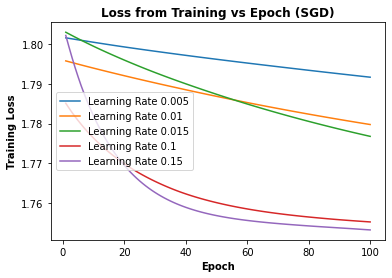

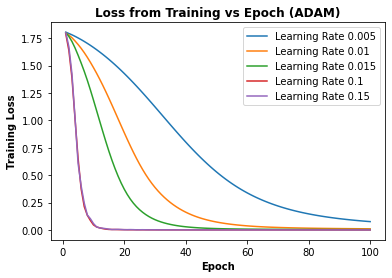

In [11]:
#############################################
### Plot the Training Loss 
#############################################
df_data_sgd = pd.DataFrame(data_sgd) # Convert Dataframe
df_data_adam = pd.DataFrame(data_adam) # Convert Dataframe

df_data_sgd.plot(x='Epoch')
plt.title("Loss from Training vs Epoch (SGD)", fontweight='bold')
plt.xlabel("Epoch", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')
plt.legend()

df_data_adam.plot(x='Epoch')
plt.title("Loss from Training vs Epoch (ADAM)", fontweight='bold')
plt.xlabel("Epoch", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')
plt.legend()

plt.show()

## Conclusion from Part 2.2:

#### - Optimizer Fixed : ADAM Optimizer
#### - Learning Rate Value Fixed : 0.015

## Part 2.2 : Tune the Hyperparameter - Aggregation Type in the GINConv() Function

### Tuning the Hyperparameter 
#### - Aggregation Type  { 'mean',  'max',  'sum' }
#### - All posssible Candidate Aggregation Type will be iterated over and tested
####  -The Validation Accuracy and Validation Loss Plot will be plotted to illustrated the most suitable Aggregation Type for the Model

In [12]:
### Extract the dimension information to initiate the Model
dim_of_features = np.shape(features_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

In [13]:
### Define the Graph Neural Network Class for Tuning Part2.2 Hyperparameter
### Build a Graph Network
class GraphNetwork_part2_2(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type):
        super(GraphNetwork_part2_2, self).__init__()
        self.graph = graph
        hidden_feat_dim01 = 30
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed

In [14]:
### Start Tuning the Hyperparameter 
### Constant Hyperparameter
epoch = 100
learning_rate = 0.015

### Tuned Hyperparameter
aggregation_type_list = ['mean', 'max', 'sum']


validation_loss_list = [] # Compile the Validation Loss for every possible Aggregation Type
validation_accuracy_list = [] # Compile the Validation Accuracy for every possible Aggregation Type
for agg_type in aggregation_type_list:
    ### Model the graph using user defined function
    model_agtype = GraphNetwork_part2_2(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=agg_type).to(device)
    optimizer_selected = optim.Adam(model_agtype.parameters(), lr = learning_rate)
    
    ### Start Training and Validation Stage
    print("\n--> Training : Start")
    start = time.time()
    epoch_list, train_loss_list, final_train_loss = train(model_agtype, 
                                        features = features_nodes_by_featdim, 
                                        labels = nodes_labels, 
                                        train_mask = train_mask_node, 
                                        epoch_val = epoch,
                                        optimizer = optimizer_selected)
    stop = time.time()
    realtime_seconds = (stop-start)
    print("--> Training : Completed\n")
    

    # Save the Model 
    save_checkpoint("model_tune2.pth", model_agtype)
    modelvalidate = GraphNetwork_part2_2(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=agg_type).to(device)
    # Load the Saved Model
    load_checkpoint("model_tune2.pth", modelvalidate)
    
    # Validation Stage 
    print("\n--> Validation : Start")
    validation_accuracy, validation_loss = validation(modelvalidate, 
                                                        features = features_nodes_by_featdim, 
                                                        labels = nodes_labels, 
                                                        val_mask = validate_mask_node)
    print("--> Validation : Completed")
    print("\nSummary of the Current Settings Results (Aggregation Type {})".format(agg_type))
    print("\nLearning Rate : {}".format(learning_rate))
    print("Aggregation Type : {}".format(agg_type))
    print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
    print("Validation Loss : {:.4f}".format(validation_loss))
    print("Training Loss : {:.4f}".format(final_train_loss))
    print("Code Execution Time : {:.4f}".format(realtime_seconds))
   
    ### Store the Accuracy and Loss
    validation_loss_list.append(validation_loss) # Compile the Validation Loss
    validation_accuracy_list.append(validation_accuracy*100) # Compile the Validation Accuracy 





--> Training : Start


c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.3319495916366577
Epoch 20: Training Loss 0.5450592041015625
Epoch 30: Training Loss 0.15319660305976868
Epoch 40: Training Loss 0.0472588948905468
Epoch 50: Training Loss 0.01905246265232563
Epoch 60: Training Loss 0.010718515142798424
Epoch 70: Training Loss 0.007506029214709997
Epoch 80: Training Loss 0.005924861878156662
Epoch 90: Training Loss 0.004973528441041708
Epoch 100: Training Loss 0.004316812381148338
--> Training : Completed

--> Model Saved to model_tune2.pth 

--> Model Loaded from model_tune2.pth 


--> Validation : Start
--> Validation : Completed

Summary of the Current Settings Results (Aggregation Type mean)

Learning Rate : 0.015
Aggregation Type : mean
Validation Accuracy 74.6914%
Validation Loss : 1.0632
Training Loss : 0.0043
Code Execution Time : 10.2693

--> Training : Start
Epoch 10: Training Loss 1.0077472925186157
Epoch 20: Training Loss 0.33698752522468567
Epoch 30: Training Loss 0.08144663274288177
Epoch 40: Training Loss 0.02971

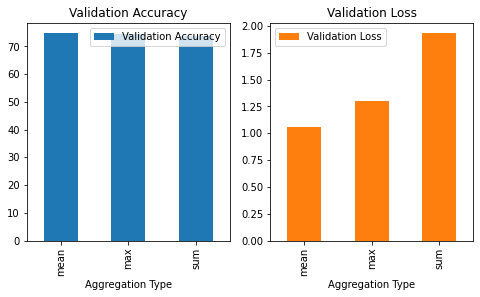

In [15]:
#############################################
### Plot the Validation Accuracy and Validation Loss 
#############################################
data_agg_type = {'Aggregation Type':aggregation_type_list,
                 'Validation Accuracy':validation_accuracy_list,
                 'Validation Loss':validation_loss_list}
df_data_agg_type = pd.DataFrame(data_agg_type) # Convert to DataFrame


# Plot the Validation Results
df_data_agg_type.plot(x='Aggregation Type', kind='bar',subplots=True, layout=(1,2), figsize=(8,4))
plt.show()

In [16]:
# Print a Table of the DataFrame
print(" Table of the Validation Accuracy and Loss for every Aggregation Type ")
df_data_agg_type.set_index(['Aggregation Type','Validation Accuracy', 'Validation Loss'])

 Table of the Validation Accuracy and Loss for every Aggregation Type 


,,
Aggregation Type,Validation Accuracy,Validation Loss
mean,74.691355,1.063216
max,74.485594,1.305643
sum,73.662549,1.930777


## Conclusion from Part 2.2:

#### - Optimizer Fixed : ADAM Optimizer
#### - Learning Rate Value Fixed : 0.015
### - Aggregation Type : mean

## Part 2.3 : Tune the Hyperparameter - Activation Function Type in the Graph Neural Network

### Tuning the Hyperparameter 
#### - Activation Function considered - {relu function, tanh function, sigmoid function}
#### - All the possible Activation Function Model will be iterated 
####  -The Training Loss will be plotted and compared just like all the previous Hyperparameter Tuning

In [17]:
### Extract the dimension information to initiate the Model
dim_of_features = np.shape(features_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

In [18]:
### Define the Graph Neural Network Class for every Activation Function type
### Build a Graph Network
class GraphNetwork_relu(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type ):
        super(GraphNetwork_relu, self).__init__()
        self.graph = graph
        hidden_feat_dim01 = 30
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed
    
class GraphNetwork_tanh(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type ):
        super(GraphNetwork_tanh, self).__init__()
        self.graph = graph
        hidden_feat_dim01 = 30
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)
        
        # the Activation Function
        self.tanh = nn.Tanh()      
        
    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = self.tanh(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed

    
class GraphNetwork_sigmoid(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type ):
        super(GraphNetwork_sigmoid, self).__init__()
        self.graph = graph
        hidden_feat_dim01 = 30
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

        # the Activation Function
        self.sigmoid = nn.Sigmoid()

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = self.sigmoid(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed

In [19]:
### Start Tuning the Hyperparameter 
### Constant Hyperparameter
learning_rate = 0.015
epoch = 100
aggregation_type = 'mean'

### Tuned Hyperparameter
# Activation Function defined in the Graph Neural Network Model's Above

dict_validation_accuracy_display = {}

#############################################
### ReLu Activation Function Graph Neural Network 
#############################################
### Model the graph using user defined function
model_relu = GraphNetwork_relu(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
optimizer_selected = optim.Adam(model_relu.parameters(), lr = learning_rate)
    
### Start Training and Validation Stage
print("\n--> Training : Start")
start = time.time()
epoch_list, train_loss_list_relu, final_train_loss = train(model_relu, 
                                        features = features_nodes_by_featdim, 
                                        labels = nodes_labels, 
                                        train_mask = train_mask_node, 
                                        epoch_val = epoch,
                                        optimizer = optimizer_selected)
stop = time.time()
realtime_seconds = (stop-start)
print("--> Training : Completed\n")
    

# Save the Model 
save_checkpoint("model_ReLu.pth", model_relu)
modelvalidate = GraphNetwork_relu(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
# Load the Saved Model
load_checkpoint("model_ReLu.pth", modelvalidate)
    
# Validation Stage 
print("\n--> Validation : Start")
validation_accuracy, validation_loss = validation(modelvalidate, 
                                                        features = features_nodes_by_featdim, 
                                                        labels = nodes_labels, 
                                                        val_mask = validate_mask_node)
print("--> Validation : Completed")
print("\nSummary of the Current Settings Results (Activation Function ReLu)")
print("\nLearning Rate : {}".format(learning_rate))
print("Aggregation Type : {}".format(aggregation_type))
print("Activation Function : {}".format('Relu'))
print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
print("Validation Loss : {:.4f}".format(validation_loss))
print("Training Loss : {:.4f}".format(final_train_loss))
print("Code Execution Time : {:.4f}".format(realtime_seconds))

# Compile for displaying as dataframe
dict_validation_accuracy_display['model_ReLu'] = [validation_accuracy*100]


#############################################
### TanH Activation Function Graph Neural Network 
#############################################
### Model the graph using user defined function
model_tanh = GraphNetwork_tanh(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)

optimizer_selected = optim.Adam(model_tanh.parameters(), lr = learning_rate)    
### Start Training and Validation Stage
print("\n--> Training : Start")
start = time.time()
epoch_list, train_loss_list_tanh, final_train_loss = train(model_tanh, 
                                        features = features_nodes_by_featdim, 
                                        labels = nodes_labels, 
                                        train_mask = train_mask_node, 
                                        epoch_val = epoch,
                                        optimizer = optimizer_selected)
stop = time.time()
realtime_seconds = (stop-start)
print("--> Training : Completed\n")
    

# Save the Model 
save_checkpoint("model_TanH.pth", model_tanh)
modelvalidate = GraphNetwork_tanh(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
# Load the Saved Model
load_checkpoint("model_TanH.pth", modelvalidate)
    
# Validation Stage 
print("\n--> Validation : Start")
validation_accuracy, validation_loss = validation(modelvalidate, 
                                                        features = features_nodes_by_featdim, 
                                                        labels = nodes_labels, 
                                                        val_mask = validate_mask_node)
print("--> Validation : Completed")
print("\nSummary of the Current Settings Results (Activation Function TanH)" )
print("\nLearning Rate : {}".format(learning_rate))
print("Aggregation Type : {}".format(aggregation_type))
print("Activation Function : {}".format('TanH'))
print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
print("Validation Loss : {:.4f}".format(validation_loss))
print("Training Loss : {:.4f}".format(final_train_loss))
print("Code Execution Time : {:.4f}".format(realtime_seconds))
   
# Compile for displaying as dataframe
dict_validation_accuracy_display['model_TanH'] = [validation_accuracy*100]
    
    
#############################################
### Sigmoid Activation Function Graph Neural Network 
#############################################    
### Model the graph using user defined function
model_sigmoid = GraphNetwork_sigmoid(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)

optimizer_selected = optim.Adam(model_sigmoid.parameters(), lr = learning_rate)    
### Start Training and Validation Stage
print("\n--> Training : Start")
start = time.time()
epoch_list, train_loss_list_sigmoid, final_train_loss = train(model_sigmoid, 
                                        features = features_nodes_by_featdim, 
                                        labels = nodes_labels, 
                                        train_mask = train_mask_node, 
                                        epoch_val = epoch,
                                        optimizer = optimizer_selected)
stop = time.time()
realtime_seconds = (stop-start)
print("--> Training : Completed\n")
    

# Save the Model 
save_checkpoint("model_Sigmoid.pth", model_sigmoid)
modelvalidate = GraphNetwork_sigmoid(G_DGL,
                            input_dim=dim_of_features,
                            output_dim=dim_of_output,
                            aggregation_type=aggregation_type).to(device)
# Load the Saved Model
load_checkpoint("model_Sigmoid.pth", modelvalidate)
    
# Validation Stage 
print("\n--> Validation : Start")
validation_accuracy, validation_loss = validation(modelvalidate, 
                                                        features = features_nodes_by_featdim, 
                                                        labels = nodes_labels, 
                                                        val_mask = validate_mask_node)
print("--> Validation : Completed")
print("\nSummary of the Current Settings Results (Activation Function Sigmoid)" )
print("\nLearning Rate : {}".format(learning_rate))
print("Aggregation Type : {}".format(aggregation_type))
print("Activation Function : {}".format('Sigmoid'))
print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
print("Validation Loss : {:.4f}".format(validation_loss))
print("Training Loss : {:.4f}".format(final_train_loss))
print("Code Execution Time : {:.4f}".format(realtime_seconds))

# Compile for displaying as dataframe
dict_validation_accuracy_display['model_Sigmoid'] = [validation_accuracy*100]




--> Training : Start


c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.2565313577651978
Epoch 20: Training Loss 0.4518768787384033
Epoch 30: Training Loss 0.12713350355625153
Epoch 40: Training Loss 0.03852942958474159
Epoch 50: Training Loss 0.015288934111595154
Epoch 60: Training Loss 0.008662734180688858
Epoch 70: Training Loss 0.00612285640090704
Epoch 80: Training Loss 0.004843810107558966
Epoch 90: Training Loss 0.004061729647219181
Epoch 100: Training Loss 0.003511399030685425
--> Training : Completed

--> Model Saved to model_ReLu.pth 

--> Model Loaded from model_ReLu.pth 


--> Validation : Start
--> Validation : Completed

Summary of the Current Settings Results (Activation Function ReLu)

Learning Rate : 0.015
Aggregation Type : mean
Activation Function : Relu
Validation Accuracy 75.3086%
Validation Loss : 1.0906
Training Loss : 0.0035
Code Execution Time : 9.3300

--> Training : Start
Epoch 10: Training Loss 0.9894614219665527
Epoch 20: Training Loss 0.23371250927448273
Epoch 30: Training Loss 0.05681121349334717
Epo

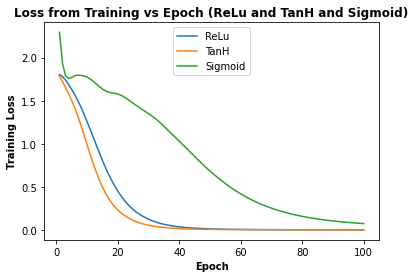

In [20]:
#############################################
### Plot the Training Loss for all the Activation Function Model
#############################################
plt.plot(epoch_list, train_loss_list_relu, epoch_list, train_loss_list_tanh, epoch_list, train_loss_list_sigmoid )
plt.title("Loss from Training vs Epoch (ReLu and TanH and Sigmoid)", fontweight='bold')
plt.xlabel("Epoch", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')
plt.legend(["ReLu","TanH", "Sigmoid"],loc='upper center' )
plt.show()


In [21]:
#############################################
### Table of the Validation Accuracy for all the Activation Function Model
#############################################
dataframe_validation_accuracy_display = pd.DataFrame(dict_validation_accuracy_display)
print("\nValidation Accuracy Table for all Activation Function")
dataframe_validation_accuracy_display.set_index(['model_ReLu','model_TanH', 'model_Sigmoid'])


Validation Accuracy Table for all Activation Function


,,
model_ReLu,model_TanH,model_Sigmoid
75.308645,74.897116,75.514406


## Conclusion from Part 2.3:

#### - Optimizer Fixed : ADAM Optimizer
#### - Learning Rate Value Fixed : 0.015
#### - Aggregation Type : mean
### - Activation Function : ReLu()

# Part 3 : Experiment with number of GINConv layers and dimension of hidden features
### From Part 2 Tuning Results the following hyperparameters will be fixed at the following value:
#### - Optimizer Fixed : ADAM Optimizer
#### - Learning Rate Value Fixed : 0.015
#### - Aggregation Type : mean
#### - Activation Function : ReLu()


### Explanation:


## Part 3.1 : Experiment with Single GINConv Layer and a range of Dimension of Hidden Features

In [22]:
### Extract the dimension information to initiate the Model
dim_of_features = np.shape(features_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

In [23]:
### Define the Graph Neural Network Class for Experimenting with GINConv Layer and a range of Dimension of Hidden Features
### Build a Graph Network
class GraphNetwork_test01(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type, hidden_dim01 ):
        super(GraphNetwork_test01, self).__init__()
        global hidden_feat_dim01
        self.graph = graph
        hidden_feat_dim01 = hidden_dim01
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed

In [24]:
### Set the Parameters Here 
learning_rate = 0.015
epoch = 100
aggregation_type = 'mean'
### Range of Dimention of Hidden Features
hidden_dim01_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]


validation_accuracy_hidden = [] # Compile the Validation Accuracy for plotting
validation_loss_hidden = [] # Compile the Validation Loss for plotting
combination_hidden = [] # Compile the dimension of hidden feature for plotting

train_loss_data = {"Epoch": list(range(1, epoch+1))} # For plotting 
for dim1 in hidden_dim01_list:
    ### Model the graph using user defined function
    model_hidden = GraphNetwork_test01(G_DGL,
                                        input_dim=dim_of_features,
                                        output_dim=dim_of_output,
                                        aggregation_type=aggregation_type,
                                        hidden_dim01= dim1).to(device)
    
    optimizer_selected = optim.Adam(model_hidden.parameters(), lr = learning_rate)    
    ### Start Training and Validation Stage
    print("\n--> Training : Start")
    start = time.time()
    epoch_list, train_loss_list, final_train_loss = train(model_hidden, 
                                            features = features_nodes_by_featdim, 
                                            labels = nodes_labels, 
                                            train_mask = train_mask_node, 
                                            epoch_val = epoch,
                                            optimizer = optimizer_selected)
    stop = time.time()
    realtime_seconds = (stop-start)
    print("--> Training : Completed\n")
        
    
    # Save the Model 
    save_checkpoint("model_hidden01.pth", model_hidden)
    modelvalidate = GraphNetwork_test01(G_DGL,
                                        input_dim=dim_of_features,
                                        output_dim=dim_of_output,
                                        aggregation_type=aggregation_type,
                                        hidden_dim01= dim1).to(device)
    # Load the Saved Model
    load_checkpoint("model_hidden01.pth", modelvalidate)
        
    # Validation Stage 
    print("\n--> Validation : Start")
    validation_accuracy, validation_loss = validation(modelvalidate, 
                                                            features = features_nodes_by_featdim, 
                                                            labels = nodes_labels, 
                                                            val_mask = validate_mask_node)
    
    # Compile the List of Training Loss vs Epoch for every possible Dimension Hidden Features for Plotting
    train_loss_data["Hidden Nodes in (Layer 1: {} )".format(hidden_feat_dim01 )] = train_loss_list
    # Compile the Validation Results for Plotting
    validation_accuracy_hidden.append(validation_accuracy*100)
    validation_loss_hidden.append(validation_loss)
    combination_hidden.append("Layer 1: {} ".format(hidden_feat_dim01 ))
    
    
    print("--> Validation : Completed")
    print("\nSummary of the Current Settings Results\n" )
    print("""Hidden Layer 1 : {}""".format(hidden_feat_dim01 ))
    print("\nLearning Rate : {}".format(learning_rate))
    print("Aggregation Type : {}".format(str(aggregation_type)))
    print("Activation Function : {}".format("Relu"))
    print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
    print("Validation Loss : {:.4f}".format(validation_loss))
    print("Training Loss : {:.4f}".format(final_train_loss))
    print("Code Execution Time : {:.4f}".format(realtime_seconds))



--> Training : Start


c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.7438039779663086
Epoch 20: Training Loss 1.6364086866378784
Epoch 30: Training Loss 1.5416477918624878
Epoch 40: Training Loss 1.4596775770187378
Epoch 50: Training Loss 1.387372612953186
Epoch 60: Training Loss 1.3231829404830933
Epoch 70: Training Loss 1.267151951789856
Epoch 80: Training Loss 1.2176387310028076
Epoch 90: Training Loss 1.1733183860778809
Epoch 100: Training Loss 1.1333539485931396
--> Training : Completed

--> Model Saved to model_hidden01.pth 

--> Model Loaded from model_hidden01.pth 


--> Validation : Start
--> Validation : Completed

Summary of the Current Settings Results

Hidden Layer 1 : 1

Learning Rate : 0.015
Aggregation Type : mean
Activation Function : Relu
Validation Accuracy 41.5638%
Validation Loss : 1.5243
Training Loss : 1.1334
Code Execution Time : 8.8051

--> Training : Start
Epoch 10: Training Loss 1.7127900123596191
Epoch 20: Training Loss 1.5283316373825073
Epoch 30: Training Loss 1.350314736366272
Epoch 40: Training L

Epoch 10: Training Loss 1.5999726057052612
Epoch 20: Training Loss 1.1791859865188599
Epoch 30: Training Loss 0.6705821752548218
Epoch 40: Training Loss 0.31924378871917725
Epoch 50: Training Loss 0.15465176105499268
Epoch 60: Training Loss 0.08188067376613617
Epoch 70: Training Loss 0.04888249561190605
Epoch 80: Training Loss 0.032473206520080566
Epoch 90: Training Loss 0.023643331602215767
Epoch 100: Training Loss 0.018427649512887
--> Training : Completed

--> Model Saved to model_hidden01.pth 

--> Model Loaded from model_hidden01.pth 


--> Validation : Start
--> Validation : Completed

Summary of the Current Settings Results

Hidden Layer 1 : 11

Learning Rate : 0.015
Aggregation Type : mean
Activation Function : Relu
Validation Accuracy 75.3086%
Validation Loss : 0.9459
Training Loss : 0.0184
Code Execution Time : 9.4006

--> Training : Start
Epoch 10: Training Loss 1.4110803604125977
Epoch 20: Training Loss 0.8451747894287109
Epoch 30: Training Loss 0.4065648317337036
Epoch 40:

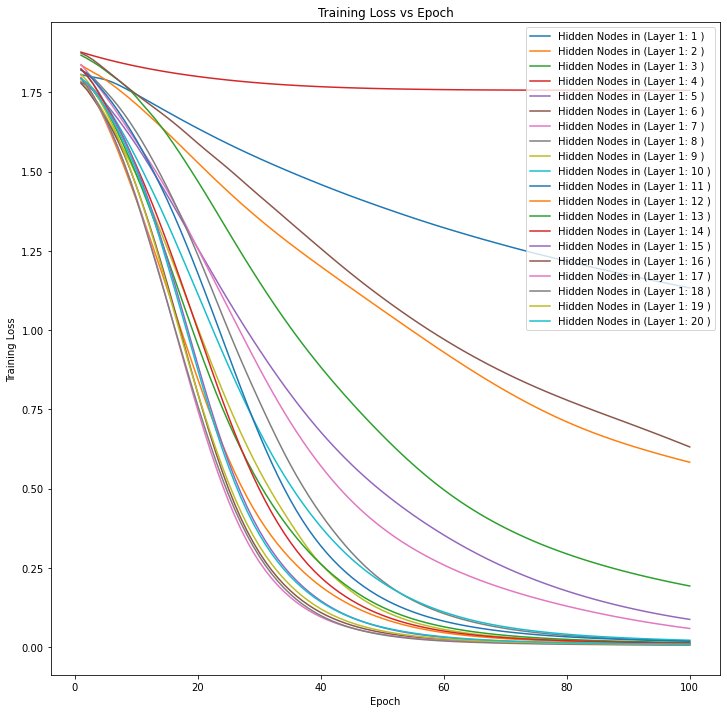

In [25]:
#############################################
### Plot the Training Loss vs Epoch
#############################################
# Plot the Training Loss vs Epoch  for every Dimension Hidden Features
df_train_loss_data = pd.DataFrame(train_loss_data) 
df_train_loss_data.plot(x='Epoch', figsize=(12,12), ylabel="Training Loss", title="Training Loss vs Epoch" )
plt.show()

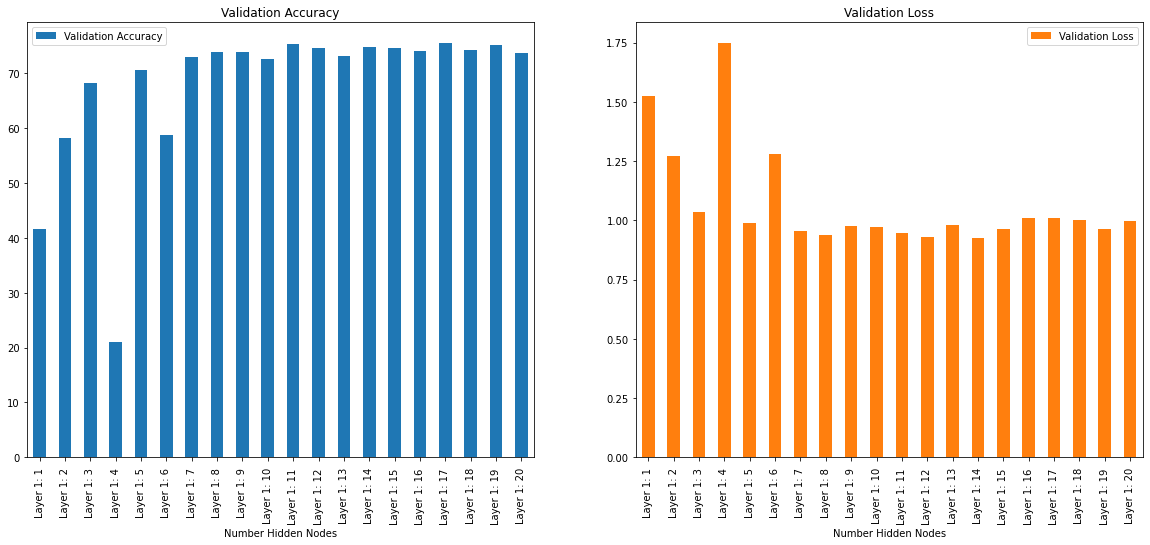

   Number Hidden Nodes  Validation Accuracy  Validation Loss
0          Layer 1: 1             41.563785         1.524335
1          Layer 1: 2             58.230454         1.272125
2          Layer 1: 3             68.312758         1.036844
3          Layer 1: 4             20.987654         1.748098
4          Layer 1: 5             70.576131         0.988135
5          Layer 1: 6             58.847737         1.278536
6          Layer 1: 7             73.045266         0.953932
7          Layer 1: 8             73.868310         0.940129
8          Layer 1: 9             73.868310         0.976101
9         Layer 1: 10             72.633743         0.970413
10        Layer 1: 11             75.308645         0.945882
11        Layer 1: 12             74.691355         0.928475
12        Layer 1: 13             73.251027         0.981921
13        Layer 1: 14             74.897116         0.925650
14        Layer 1: 15             74.691355         0.962117
15        Layer 1: 16   

In [26]:
#############################################
### Plot the Validation Accuracy and Validation Loss 
#############################################
# Plot the Validation Accuracy and Validation Loss for every Dimension Hidden Features
data = {'Number Hidden Nodes': combination_hidden,
                  'Validation Accuracy':validation_accuracy_hidden,
                  'Validation Loss':validation_loss_hidden}
df_data = pd.DataFrame(data)
df_data.plot(x='Number Hidden Nodes', kind='bar', subplots=True, layout=(1,2), figsize=(20,8))
plt.show()
print(df_data)

## Part 3.2 : Experiment with Double GINConv Layer and a range of Dimension of Hidden Features

In [27]:
### Extract the dimension information to initiate the Model
dim_of_features = np.shape(features_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

In [28]:
### Define the Graph Neural Network Class for Experimenting with GINConv Layer and a range of Dimension of Hidden Features
### Build a Graph Network
class GraphNetwork_test02(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type, hidden_dim01, hidden_dim12):
        super(GraphNetwork_test02, self).__init__()
        global hidden_feat_dim01, hidden_feat_dim12
        self.graph = graph
        hidden_feat_dim01 = hidden_dim01
        hidden_feat_dim12 = hidden_dim12
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, hidden_feat_dim12)
        self.layer1 = GINConv(lin1, aggregation_type)
        lin2 = torch.nn.Linear(hidden_feat_dim12, output_dim)
        self.layer2 = GINConv(lin2, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer2(self.graph, h_embed)
        return h_embed

In [29]:
### Set the Parameters Here 
learning_rate = 0.015
epoch = 100
aggregation_type = 'mean'
### Range of Dimention of Hidden Features
hidden_dim01_list = [15]
hidden_dim12_list = [15,20,25,30]

validation_accuracy_hidden = [] # Compile the Validation Accuracy for plotting
validation_loss_hidden = [] # Compile the Validation Loss for plotting
combination_hidden = [] # Compile the dimension of hidden feature for plotting

train_loss_data = {"Epoch": list(range(1, epoch+1))} # For plotting
for dim1 in hidden_dim01_list: 
    for dim2 in hidden_dim12_list:
        ### Model the graph using user defined function
        model_hidden = GraphNetwork_test02(G_DGL,
                                            input_dim=dim_of_features,
                                            output_dim=dim_of_output,
                                            aggregation_type=aggregation_type,
                                            hidden_dim01= dim1,
                                            hidden_dim12= dim2).to(device)
        
        optimizer_selected = optim.Adam(model_hidden.parameters(), lr = learning_rate)    
        ### Start Training and Validation Stage
        print("\n--> Training : Start")
        start = time.time()
        epoch_list, train_loss_list, final_train_loss = train(model_hidden, 
                                                features = features_nodes_by_featdim, 
                                                labels = nodes_labels, 
                                                train_mask = train_mask_node, 
                                                epoch_val = epoch,
                                                optimizer = optimizer_selected)
        stop = time.time()
        realtime_seconds = (stop-start)
        print("--> Training : Completed\n")
            
        
        # Save the Model 
        save_checkpoint("model_hidden02.pth", model_hidden)
        modelvalidate = GraphNetwork_test02(G_DGL,
                                            input_dim=dim_of_features,
                                            output_dim=dim_of_output,
                                            aggregation_type=aggregation_type,
                                            hidden_dim01= dim1,
                                            hidden_dim12= dim2).to(device)
        # Load the Saved Model
        load_checkpoint("model_hidden02.pth", modelvalidate)
            
        # Validation Stage 
        print("\n--> Validation : Start")
        validation_accuracy, validation_loss = validation(modelvalidate, 
                                                                features = features_nodes_by_featdim, 
                                                                labels = nodes_labels, 
                                                                val_mask = validate_mask_node)
        
        train_loss_data["Hidden Nodes in (Layer 1: {} Layer 2: {})".format(hidden_feat_dim01, hidden_feat_dim12)] = train_loss_list

        validation_accuracy_hidden.append(validation_accuracy*100)
        validation_loss_hidden.append(validation_loss)
        combination_hidden.append("layer 1: {} Layer 2: {}".format(hidden_feat_dim01, hidden_feat_dim12))
        
        
        print("--> Validation : Completed")
        print("\nSummary of the Current Settings Results\n" )
        print(""""Hidden Layer 1 : {} Hidden Layer 2 : {} """.format(hidden_feat_dim01, hidden_feat_dim12))
        print("\nLearning Rate : {}".format(learning_rate))
        print("Aggregation Type : {}".format(str(aggregation_type)))
        print("Activation Function : {}".format("Relu"))
        print("Validation Accuracy {:.4f}%".format(validation_accuracy*100))
        print("Validation Loss : {:.4f}".format(validation_loss))
        print("Training Loss : {:.4f}".format(final_train_loss))
        print("Code Execution Time : {:.4f}".format(realtime_seconds))
            




--> Training : Start


c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.4530713558197021
Epoch 20: Training Loss 0.6473879814147949
Epoch 30: Training Loss 0.14355523884296417
Epoch 40: Training Loss 0.027398057281970978
Epoch 50: Training Loss 0.007106541655957699
Epoch 60: Training Loss 0.003221172606572509
Epoch 70: Training Loss 0.002022720407694578
Epoch 80: Training Loss 0.0014720591716468334
Epoch 90: Training Loss 0.0011601829901337624
Epoch 100: Training Loss 0.0009581256890669465
--> Training : Completed

--> Model Saved to model_hidden02.pth 

--> Model Loaded from model_hidden02.pth 


--> Validation : Start
--> Validation : Completed

Summary of the Current Settings Results

"Hidden Layer 1 : 15 Hidden Layer 2 : 15 

Learning Rate : 0.015
Aggregation Type : mean
Activation Function : Relu
Validation Accuracy 71.8107%
Validation Loss : 1.9526
Training Loss : 0.0010
Code Execution Time : 8.9634

--> Training : Start
Epoch 10: Training Loss 1.3403788805007935
Epoch 20: Training Loss 0.4918982982635498
Epoch 30: Training 

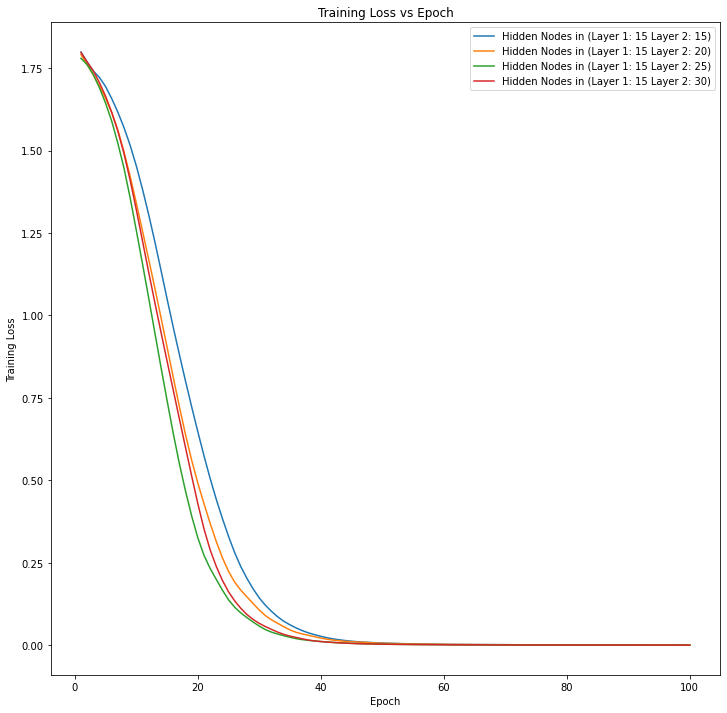

In [30]:
#############################################
### Plot the Training Loss vs Epoch
#############################################
# Plot the Training Loss vs Epoch  for every Dimension Hidden Features
df_train_loss_data = pd.DataFrame(train_loss_data)
df_train_loss_data.plot(x='Epoch', figsize=(12,12), ylabel="Training Loss", title="Training Loss vs Epoch" )
plt.show()

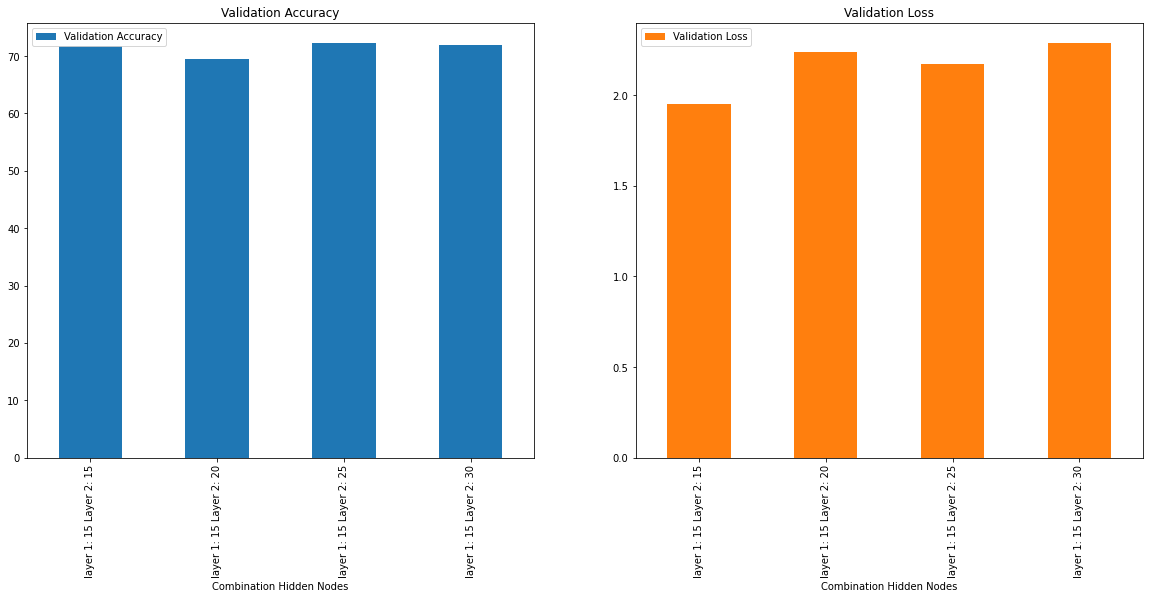

  Combination Hidden Nodes  Validation Accuracy  Validation Loss
0  layer 1: 15 Layer 2: 15            71.810699         1.952635
1  layer 1: 15 Layer 2: 20            69.547325         2.238719
2  layer 1: 15 Layer 2: 25            72.222221         2.175020
3  layer 1: 15 Layer 2: 30            72.016460         2.286615


In [31]:
#############################################
### Plot the Validation Accuracy and Validation Loss 
#############################################
# Plot the Validation Accuracy and Validation Loss for every Dimension Hidden Features
data = {'Combination Hidden Nodes': combination_hidden,
                  'Validation Accuracy':validation_accuracy_hidden,
                  'Validation Loss':validation_loss_hidden}

df_data = pd.DataFrame(data)
df_data.plot(x='Combination Hidden Nodes', kind='bar', subplots=True, layout=(1,2), figsize=(20,8))
plt.show()
print(df_data)

# Part 4 : Start Training and Validation Stage with the Final Graph Neural Network Model Hyperparameter Settings with Real Graph and Random Graph

In [32]:
### Define the Final Graph Neural Network Class for Training and Validation for Real Graph and Random Graph 
### Build the Final Graph Neural Network
class GraphNetwork_f(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type, hidden_dim01 ):
        super(GraphNetwork_f, self).__init__()
        global hidden_feat_dim01
        self.graph = graph
        hidden_feat_dim01 = hidden_dim01
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed

## Part 4.1 Real Graph : Training Stage 

In [33]:
### Initiate the GraphNetwork 
dim_of_features = np.shape(features_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

### Set the Parameters Here 
learning_rate = 0.015 # <== 
aggregation_type = 'mean'  # <==
epoch = 100  # <==

### Range of Dimension of Hidden Features
hidden_dim01= 15

### Model the graph using user defined function
model = GraphNetwork_f(G_DGL,
                        input_dim=dim_of_features,
                        output_dim=dim_of_output,
                        aggregation_type=aggregation_type,
                        hidden_dim01= hidden_dim01).to(device)
optimizer_selected = optim.Adam(model.parameters(), lr = learning_rate) # <==
# Print the Parameter of the Model (which is a GraphNetwork)
print("Parameter of the Model")
print(model.parameters)

### Start Training Stage
print("")
print("-"*50) 
print("--> Training : Start")
start = time.time()
epoch_list, train_loss_list, final_train_loss = train(model, 
                                    features = features_nodes_by_featdim, 
                                    labels = nodes_labels, 
                                    train_mask = train_mask_node,
                                    epoch_val = epoch,
                                    optimizer = optimizer_selected)
stop = time.time()
realtime_seconds = (stop-start)
print("")
print("--> Training : Completed")

Parameter of the Model
<bound method Module.parameters of GraphNetwork_f(
  (layer0): GINConv(
    (apply_func): Linear(in_features=3703, out_features=15, bias=True)
  )
  (layer1): GINConv(
    (apply_func): Linear(in_features=15, out_features=6, bias=True)
  )
)>

--------------------------------------------------
--> Training : Start


c:\users\emily\appdata\local\programs\python\python39\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.436418890953064
Epoch 20: Training Loss 0.7994058132171631
Epoch 30: Training Loss 0.3171948194503784
Epoch 40: Training Loss 0.11747852712869644
Epoch 50: Training Loss 0.048659563064575195
Epoch 60: Training Loss 0.024806726723909378
Epoch 70: Training Loss 0.015683472156524658
Epoch 80: Training Loss 0.011514750309288502
Epoch 90: Training Loss 0.009209172800183296
Epoch 100: Training Loss 0.007742011919617653

--> Training : Completed


### Plot the Training Loss Graph 

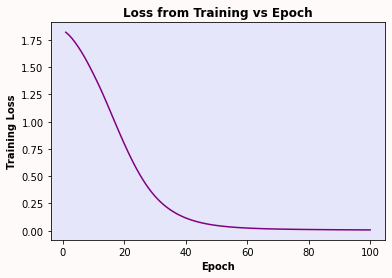

In [34]:
### Plot the Training Loss 
plt.figure(facecolor='snow')
ax = plt.axes()
ax.set_facecolor('lavender')

plt.plot(epoch_list, train_loss_list, color = "purple")
plt.title("Loss from Training vs Epoch", fontweight='bold')
plt.xlabel("Epoch", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')
plt.show()

### Real Graph : Save your model at the Last Epoch

In [35]:
# Save the Model 
save_checkpoint("best_model.pth", model)

--> Model Saved to best_model.pth 



## Part 4.2 Real Graph : Validation Stage 

In [36]:
print("-"*50) 
print("--> Validation : Start")
modelvalidate = GraphNetwork_f(G_DGL,
                        input_dim=dim_of_features,
                        output_dim=dim_of_output,
                        aggregation_type=aggregation_type,
                        hidden_dim01= hidden_dim01).to(device)
# Load the Saved Model
load_checkpoint("best_model.pth", modelvalidate)
validation_accuracy, validation_loss = validation(modelvalidate, 
                                                    features = features_nodes_by_featdim, 
                                                    labels = nodes_labels, 
                                                    val_mask = validate_mask_node)
print("--> Validation : Completed")
print("-"*50)
print("\nValidation Accuracy {:.4}%".format(validation_accuracy*100))

--------------------------------------------------
--> Validation : Start
--> Model Loaded from best_model.pth 

--> Validation : Completed
--------------------------------------------------

Validation Accuracy 74.49%


In [37]:
### Display the Hyperparameters and the Results from Training and Validation
display_hyperparameter_results(modelvalidate,
                                   aggregation_type,
                                   type(optimizer_selected),
                                   learning_rate,
                                   epoch,
                                   final_train_loss,
                                   validation_loss,
                                   validation_accuracy,
                                   realtime_seconds)



            Hyperparameter and Results from Training and Validation
            
            Model Parameters:
            GraphNetwork_f(
  (layer0): GINConv(
    (apply_func): Linear(in_features=3703, out_features=15, bias=True)
  )
  (layer1): GINConv(
    (apply_func): Linear(in_features=15, out_features=6, bias=True)
  )
)
            
            Aggregation Type : mean
            Optimizer Function : <class 'torch.optim.adam.Adam'>       
            Optimizer Learning Rate : 0.015
            Loss Function : Negative Log Likelihood Loss
            
            Training Epoch : 100
            
            Training Loss : 0.00774
            Validation Loss : 0.94507
            Validation Accuracy : 74.48559%
            Code Execution Time (Training Time) : 8.70919
            
            


### Real Graph : Testing Stage with Test Set 

In [38]:
### Uncomment this section to Test the Model Classification Accuracy 
print("-"*50) 
print("Testing Stage")
print("-"*50)
test_mask = validate_mask_node  # <===== !! Change Test Mask Here !!
modeltest = GraphNetwork_f(G_DGL,
                        input_dim=dim_of_features,
                        output_dim=dim_of_output,
                        aggregation_type=aggregation_type,
                        hidden_dim01= hidden_dim01).to(device)
load_checkpoint("best_model.pth", modeltest)
# the test_mask here is hidden for you. you can replace the test_mask with the val_mask.
test_accuracy = test(modeltest, 
                features = features_nodes_by_featdim, 
                labels = nodes_labels, 
                test_mask = test_mask) # <===== !! Test Mask Inserted Here !!
print("\nTesting Accuracy {:.4}%".format(test_accuracy*100))

--------------------------------------------------
Testing Stage
--------------------------------------------------
--> Model Loaded from best_model.pth 


Testing Accuracy 74.49%


## Part 4.3 Random Graph : Training Stage  
### Generate a random feature matrix with the same shape

In [39]:
### Define the Final Graph Neural Network Class for Training and Validation for Real Graph and Random Graph 
### Build the Final Graph Neural Network
class GraphNetwork_f(nn.Module):
    def __init__(self, graph, input_dim, output_dim, aggregation_type, hidden_dim01 ):
        super(GraphNetwork_f, self).__init__()
        global hidden_feat_dim01
        self.graph = graph
        hidden_feat_dim01 = hidden_dim01
        aggregation_type = aggregation_type
        
        lin0 = torch.nn.Linear(input_dim, hidden_feat_dim01)
        self.layer0 = GINConv(lin0, aggregation_type)
        lin1 = torch.nn.Linear(hidden_feat_dim01, output_dim)
        self.layer1 = GINConv(lin1, aggregation_type)

    def forward (self, h_embed):
        h_embed = self.layer0(self.graph, h_embed)
        h_embed = F.relu(h_embed)
        h_embed = self.layer1(self.graph, h_embed)
        return h_embed

In [40]:
### Generate the graph in networkX before converting to DGL graph
np.random.seed(5008)
features_random_nodes_by_featdim = np.random.rand(np.shape(features_nodes_by_featdim)[0],np.shape(features_nodes_by_featdim)[1])
#print(features_random_nodes_by_featdim)
print(np.shape(features_random_nodes_by_featdim)[1])

3703


### Random Graph : Data Preparation Stage 

In [41]:
### Generate the graph in networkX before converting to DGL graph
G_networkx_random = nx.DiGraph()
# Add the Node ID
G_networkx_random.add_nodes_from(nodes_id)
# Add the Edges with weight = 1
iterable_edges = []
for i in range(len(source_nodes)):
    iterable_edges.append((source_nodes[i], target_nodes[i], 1.0))
G_networkx_random.add_weighted_edges_from(iterable_edges)

In [42]:
print("""
      =========================================
           Random Deep Graph Neural Network
      =========================================
      \n""")
### Transform networkx graph network to DGL graph
G_DGL_random = dgl.from_networkx(G_networkx_random)
print("After Transforming the Random Graph from NetworkX:")
print('- Deep Graph have %d nodes.' % G_DGL_random.number_of_nodes())
print('- Deep Graph have %d edges.' % G_DGL_random.number_of_edges())
G_DGL_random = dgl.add_self_loop(G_DGL_random)
print("After Adding Self Loop:")
print('- Deep Graph have %d nodes.' % G_DGL_random.number_of_nodes())
print('- Deep Graph have %d edges.' % G_DGL_random.number_of_edges())

### Setting up DGL to the Device 
cuda_available = torch.cuda.is_available()
print("\nCUDA Availability: {}".format(cuda_available))

G_DGL_random = G_DGL_random.to(device)
print("\nGraph Neural Network Setting")
print(G_DGL_random)



           Random Deep Graph Neural Network
      

After Transforming the Random Graph from NetworkX:
- Deep Graph have 3327 nodes.
- Deep Graph have 12431 edges.
After Adding Self Loop:
- Deep Graph have 3327 nodes.
- Deep Graph have 15758 edges.

CUDA Availability: False

Graph Neural Network Setting
Graph(num_nodes=3327, num_edges=15758,
      ndata_schemes={}
      edata_schemes={})


### Random Graph : Training Stage 

In [43]:
### Initiate the GraphNetwork 
dim_of_features_random = np.shape(features_random_nodes_by_featdim)[1]
dim_of_output = total_num_node_label

### Set the Parameters Here 
learning_rate = 0.015 # <== 
aggregation_type = 'mean'  # <==
epoch = 100  # <==

### Range of Dimension of Hidden Features
hidden_dim01= 15

### Model the graph using user defined function
model_random = GraphNetwork_f(G_DGL_random,
                        input_dim=dim_of_features_random,
                        output_dim=dim_of_output,
                        aggregation_type=aggregation_type,
                        hidden_dim01= hidden_dim01).to(device)
optimizer_selected = optim.Adam(model_random.parameters(), lr = learning_rate) # <==

### Setting up the Model to the Device
#model_random = model_random.to(device)
# Print the Parameter of the Model (which is a GraphNetwork)
print("Parameter of the Model")
print(model_random.parameters)


### Start Training Stage
print("")
print("-"*50) 
print("--> Training : Start")
start = time.time()
epoch_list_random, train_loss_list_random, final_train_loss_random = train(model_random, 
                                                                           features = features_random_nodes_by_featdim, 
                                                                            labels = nodes_labels, 
                                                                            train_mask = train_mask_node,
                                                                            epoch_val = epoch,
                                                                            optimizer = optimizer_selected)
                                    
stop = time.time()
randomtime_seconds = (stop-start)
print("")
print("--> Training : Completed")

Parameter of the Model
<bound method Module.parameters of GraphNetwork_f(
  (layer0): GINConv(
    (apply_func): Linear(in_features=3703, out_features=15, bias=True)
  )
  (layer1): GINConv(
    (apply_func): Linear(in_features=15, out_features=6, bias=True)
  )
)>

--------------------------------------------------
--> Training : Start


<ipython-input-2-20c53656246c>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float).to(device)
<ipython-input-2-20c53656246c>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


Epoch 10: Training Loss 1.7911983728408813
Epoch 20: Training Loss 1.7876884937286377
Epoch 30: Training Loss 1.7785784006118774
Epoch 40: Training Loss 1.7703311443328857
Epoch 50: Training Loss 1.764449119567871
Epoch 60: Training Loss 1.7607898712158203
Epoch 70: Training Loss 1.7587276697158813
Epoch 80: Training Loss 1.757648229598999
Epoch 90: Training Loss 1.7571135759353638
Epoch 100: Training Loss 1.7568602561950684

--> Training : Completed


### Plot the Training Loss for the Random Graph 

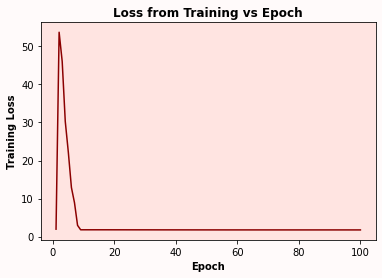

In [44]:
### Plot the Training Loss 
plt.figure(facecolor='snow')
ax2 = plt.axes()
ax2.set_facecolor('mistyrose')

plt.plot(epoch_list_random, train_loss_list_random, color = "darkred")
plt.title("Loss from Training vs Epoch", fontweight='bold')
plt.xlabel("Epoch", fontweight='bold')
plt.ylabel("Training Loss", fontweight='bold')
plt.show()

### Random Graph : Save your model at the Last Epoch

In [45]:
# Save the Model 
save_checkpoint("best_model_random.pth", model)

--> Model Saved to best_model_random.pth 



## Part 4.4 Random Graph : Validation Stage 

In [46]:
print("-"*50) 
print("--> Validation : Start")
modelvalidate_random = GraphNetwork_f(G_DGL_random,
                        input_dim=dim_of_features_random,
                        output_dim=dim_of_output,
                        aggregation_type=aggregation_type,
                        hidden_dim01= hidden_dim01).to(device)
# Load the Saved Model
load_checkpoint("best_model_random.pth", modelvalidate_random)
validation_accuracy, validation_loss = validation(modelvalidate_random, 
                                               features = features_random_nodes_by_featdim, 
                                               labels = nodes_labels, 
                                               val_mask = validate_mask_node)
print("--> Validation : Completed")
print("-"*50)
print("\nValidation Accuracy {:.4}%".format(validation_accuracy*100))


--------------------------------------------------
--> Validation : Start
--> Model Loaded from best_model_random.pth 

--> Validation : Completed
--------------------------------------------------

Validation Accuracy 20.99%


In [47]:
### Display the Hyperparameters and the Results from Training and Validation
display_hyperparameter_results(modelvalidate_random,
                                   aggregation_type,
                                   type(optimizer_selected),
                                   learning_rate,
                                   epoch,
                                   final_train_loss_random,
                                   validation_loss,
                                   validation_accuracy,
                                   randomtime_seconds)


            Hyperparameter and Results from Training and Validation
            
            Model Parameters:
            GraphNetwork_f(
  (layer0): GINConv(
    (apply_func): Linear(in_features=3703, out_features=15, bias=True)
  )
  (layer1): GINConv(
    (apply_func): Linear(in_features=15, out_features=6, bias=True)
  )
)
            
            Aggregation Type : mean
            Optimizer Function : <class 'torch.optim.adam.Adam'>       
            Optimizer Learning Rate : 0.015
            Loss Function : Negative Log Likelihood Loss
            
            Training Epoch : 100
            
            Training Loss : 1.75686
            Validation Loss : 1691.22534
            Validation Accuracy : 20.98765%
            Code Execution Time (Training Time) : 8.76151
            
            


### Random Graph : Testing Stage with Test Set 

In [48]:
### Uncomment this section to Test the Random Graph Model 
print("-"*50) 
print("Testing Stage")
print("-"*50)
test_mask = validate_mask_node  # <===== !! Change Test Mask Here !!
modeltest_random = GraphNetwork_f(G_DGL_random,
                        input_dim=dim_of_features_random,
                        output_dim=dim_of_output,
                        aggregation_type=aggregation_type,
                        hidden_dim01= hidden_dim01,).to(device)
load_checkpoint("best_model_random.pth", modeltest_random)
# the test_mask here is hidden for you. you can replace the test_mask with the val_mask.
test_accuracy = test(modeltest_random, 
                        features = features_random_nodes_by_featdim, 
                        labels = nodes_labels, 
                        test_mask = test_mask)
print("\nTesting Accuracy {:.4}%".format(test_accuracy*100))

--------------------------------------------------
Testing Stage
--------------------------------------------------
--> Model Loaded from best_model_random.pth 


Testing Accuracy 20.99%
